In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [3]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "P_" in node:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [4]:
# Define positions manually
pos = {}

for i in range(6):

    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , 0)
        pos[f'P_D{i}'] = ((i * 3 - 1)  , -1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , -1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , -2)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , -2)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, 3)
        pos[f'I_D{i}'] = (i * 3 - 1, 2)
        pos[f'I_V{i}'] = (i * 3 + 1, 2)
        pos[f'I_IP{i}'] = (i * 3 - 1, 1)
        pos[f'I_A{i}'] = (i * 3 + 1, 1)
    else:
         # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = ((i * 3)  , (0) - 1)
        pos[f'P_D{i}'] = ((i * 3 - 1)  ,( -1) - 1)
        pos[f'P_V{i}'] = ((i * 3 + 1)  , (-1) - 1)
        pos[f'P_IP{i}'] = ((i * 3 - 1)  , (-2) - 1)
        pos[f'P_A{i}'] = ((i * 3 + 1)  , (-2) - 1)

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3, (3) + 1)
        pos[f'I_D{i}'] = (i * 3 - 1, (2) + 1)
        pos[f'I_V{i}'] = (i * 3 + 1, (2) + 1)
        pos[f'I_IP{i}'] = (i * 3 - 1, (1) + 1)
        pos[f'I_A{i}'] = (i * 3 + 1, (1) + 1)


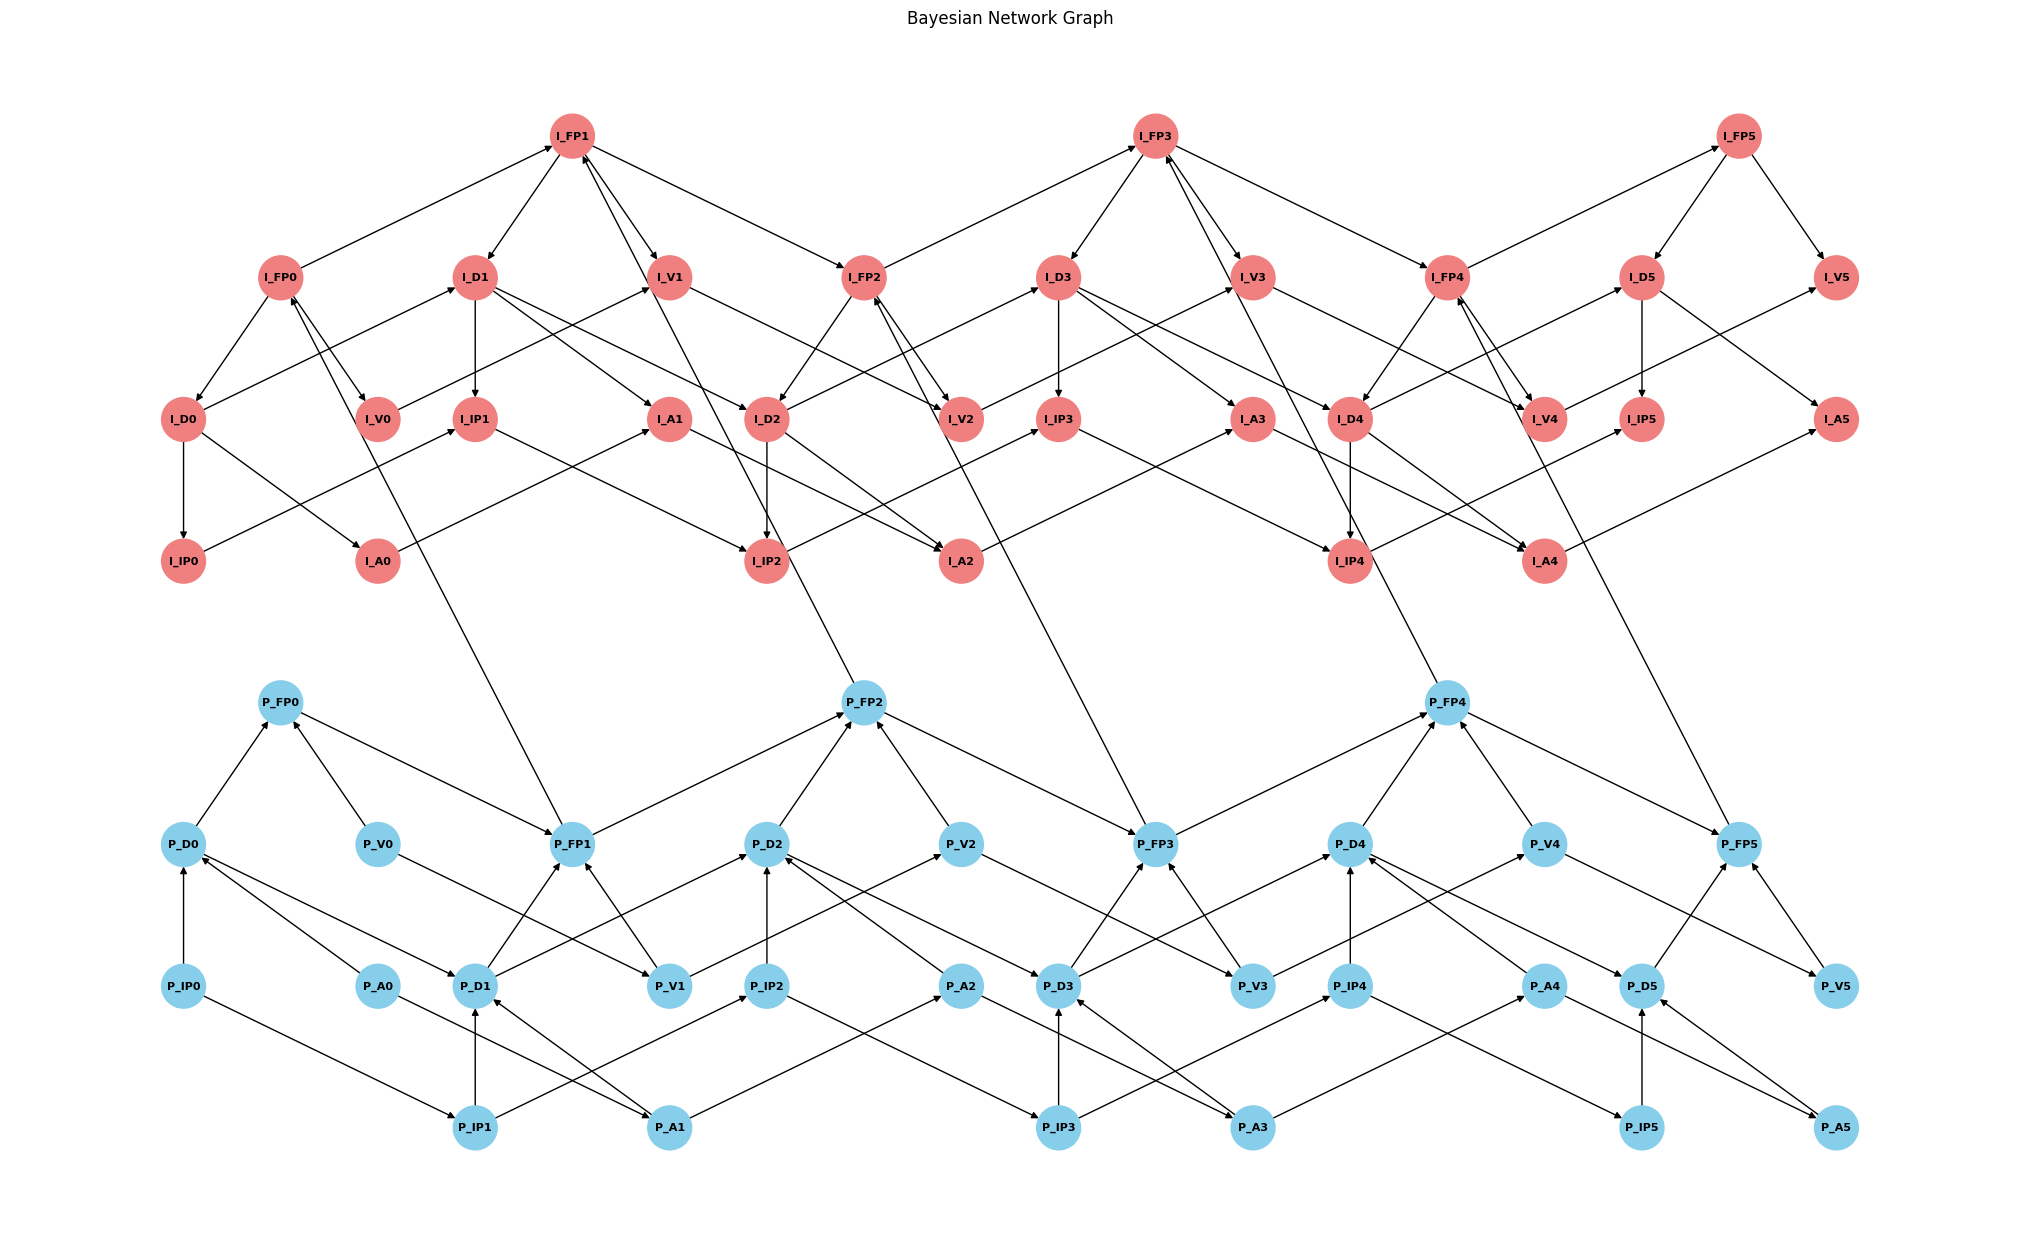

In [5]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    GT.add_nodes_from([
        f'P_FP{i}', f'P_D{i}', f'P_V{i}',
        f'P_IP{i}', f'P_A{i}',
        f'I_FP{i}', f'I_D{i}', f'I_V{i}',
        f'I_IP{i}', f'I_A{i}'
    ])
    
    GT.add_edges_from([
        ( f'P_D{i}', f'P_FP{i}'),
        (f'P_IP{i}', f'P_D{i}'),
        (f'P_A{i}', f'P_D{i}'),
        ( f'P_V{i}',f'P_FP{i}'),
        ( f'I_FP{i}', f'I_D{i}'),
        (f'I_D{i}',f'I_IP{i}'),
        (f'I_D{i}',f'I_A{i}'),
        ( f'I_FP{i}',f'I_V{i}')
    ])

    if i < 5:
        # Connect corresponding nodes between time slices
        GT.add_edges_from([
            (f'P_FP{i}', f'P_FP{i + 1}'),
            (f'P_D{i}', f'P_D{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),
            (f'P_IP{i}', f'P_IP{i + 1}'),
            (f'P_A{i}', f'P_A{i + 1}'),
            (f'I_FP{i}', f'I_FP{i + 1}'),
            (f'I_D{i}', f'I_D{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}'),
            (f'I_IP{i}', f'I_IP{i + 1}'),
            (f'I_A{i}', f'I_A{i + 1}')
        ])
        
        # Edge between interceptor and projectile across time slices
        GT.add_edge(f'P_FP{i + 1}', f'I_FP{i}')

visualise(GT, pos)


In [6]:
# CPDs for Projectile Nodes
for i in range(6):
    if i == 0:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 0.9, 0.3],  # Assuming offset is replaced with beta's first value
            1.0, 
            []
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            []
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0],  # No evidence, so beta is just the offset value
            0.1,
            []
        )
    else:
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [5.0, 0.9, 0.7],  # Assuming offset is replaced with beta's first value
            2.0, 
            [ f'P_V{i}', f'P_D{i}', f'P_FP{i - 1}']
        )

        cpd_P_D = LinearGaussianCPD(
            f'P_D{i}', 
            [0.0, 0.5, 0.3],  # Assuming offset is replaced with beta's first value
            0.5,
            [f'P_A{i}', f'P_IP{i}',  f'P_D{i - 1}']
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 0.9, 0.3],  # Assuming offset is replaced with beta's first value
            1.0, 
            [ f'P_V{i - 1}']
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_IP{i - 1}']
        )

        cpd_P_A = LinearGaussianCPD(
            f'P_A{i}',
            [45.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'P_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_P_FP, cpd_P_D, cpd_P_V, cpd_P_IP, cpd_P_A)

# CPDs for Interceptor Nodes
for i in range(6):

    if i == 0:

        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                []
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5, 0.3, 0.2],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8, 0.3, 0.3],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}']
        )

    else:
        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'P_FP{i+1}',  f'I_FP{i - 1}']
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [5.0, 0.9, 0.7, 0.8],  # Assuming offset is replaced with beta's first value
                3.0, 
                [f'I_FP{i - 1}']
            )

        cpd_I_D = LinearGaussianCPD(
            f'I_D{i}', 
            [0.0, 0.5, 0.3, 0.2],  # Assuming offset is replaced with beta's first value
            0.5,
            [ f'I_FP{i}', f'I_D{i - 1}']
        )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [15.0, 0.8, 0.3, 0.3],  # Assuming offset is replaced with beta's first value
            1.5, 
            [f'I_FP{i}',  f'I_V{i - 1}']
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0],  # No evidence, so beta is just the offset value
            0.1,
            [f'I_D{i}' , f'I_IP{i - 1}']
        )

        cpd_I_A = LinearGaussianCPD(
            f'I_A{i}',
            [45.0],  # Depends on the projectile's angle
            0.2,
            [f'I_D{i}' ,  f'I_A{i - 1}']
        )


    # Add CPDs to the network
    GT.add_cpds(cpd_I_FP, cpd_I_D, cpd_I_V, cpd_I_IP, cpd_I_A)

In [7]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [34]:
import numpy as np
import pandas as pd

def sample_from_joint_gaussian(mean, covariance, size=1):
    """Samples from a joint Gaussian distribution with given mean and covariance."""
    mean = np.array(mean).flatten()
    covariance = np.array(covariance)
    
    if mean.shape[0] != covariance.shape[0]:
        raise ValueError("Mean and covariance dimensions do not match.")
    
    return np.random.multivariate_normal(mean, covariance, size=size)

def forward_sample_from_dbn(JGD, n_samples=1000):
    """Perform forward sampling from a joint Gaussian distribution."""
    # Extract mean and covariance from the joint Gaussian distribution
    mean = JGD.mean.flatten()
    covariance = JGD.covariance
    
    # Sample from the joint Gaussian distribution
    sampled_data = sample_from_joint_gaussian(mean, covariance, size=n_samples)
    
    # Create a DataFrame from the sampled data
    sample_df = pd.DataFrame(sampled_data, columns=JGD.variables)
    
    return sample_df

# Generate samples
n_samples = 1000
JGD = GT.to_joint_gaussian()
samples_df = forward_sample_from_dbn(JGD, n_samples=n_samples)

# Save to CSV
samples_df.to_csv("trajectory_data.csv", index=False)
print(f"Generated {n_samples} samples and saved to trajectory_data.csv")



Generated 1000 samples and saved to trajectory_data.csv


C:\Users\suvar\AppData\Local\Temp\ipykernel_52564\3503028770.py:12: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(mean, covariance, size=size)
